# Figure 3: Explained variance of Denmark Strait freshwater transport reconstructions

This notebook will reproduce Figure 3 from  E. Boland et al. 2025 (doi to come). This requires input datafiles (expects to find them in ../data_out) to run - please see the README for details.

Please attribute any plots or code from this notebook using the DOI from Zenodo: TO COME

E Boland Jan 2025 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cmasher as cmr
import numpy as np
from cycler import cycler

In [3]:
ev_dir='../data_out/ev'

In [4]:
eyears=['2000','2006','2014']
plotvars=['all_OCE','wind_OCE','adxx_qnetXoceQnet_sum', 'adxx_empmrXoceFWflx_sum']
plotvar_labels=dict(zip(plotvars,['Total Recon','Wind Stress','Heat','Fresh Water']))

In [5]:
mth=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
mthi=dict(zip(mth,[i for i in range(1,13)]))

In [6]:
cum_ev={}
cum_ev_bym={}
for year in eyears:
        cum_ev[year]=xr.open_dataset(f'{ev_dir}/{year}/horflux_fw_denm_cumev_bylag_byvar_{year}.nc').assign_coords({'eyear':year})
        cum_ev_bym[year]=xr.open_dataset(f'{ev_dir}/{year}/horflux_fw_denm_cumev_bylag_byvar_bymonth_{year}.nc').assign_coords({'eyear':year,'lag_years':cum_ev[year].lag_years})

In [7]:
lag_ds=[]
lag_total=[]
for year in eyears:
    lagmax_total=cum_ev[year].idxmax('lag_years').squeeze().load()
    lag_total.append(lagmax_total)
    lagmax=cum_ev_bym[year].idxmax('lag_years').squeeze().load()
    lag_ds.append(lagmax.assign_coords({'eyear':year}))
lag_ds=xr.concat(lag_ds,'eyear')
lag_total=xr.concat(lag_total,'eyear')

In [8]:
for var in plotvars:
    print(f'{var} {lag_total[var].mean("eyear").data:1.3f} {lag_total[var].std("eyear").data:1.3f}')

all_OCE -2.136 0.840
wind_OCE -1.676 0.189
adxx_qnetXoceQnet_sum -0.424 0.043
adxx_empmrXoceFWflx_sum -4.459 0.129


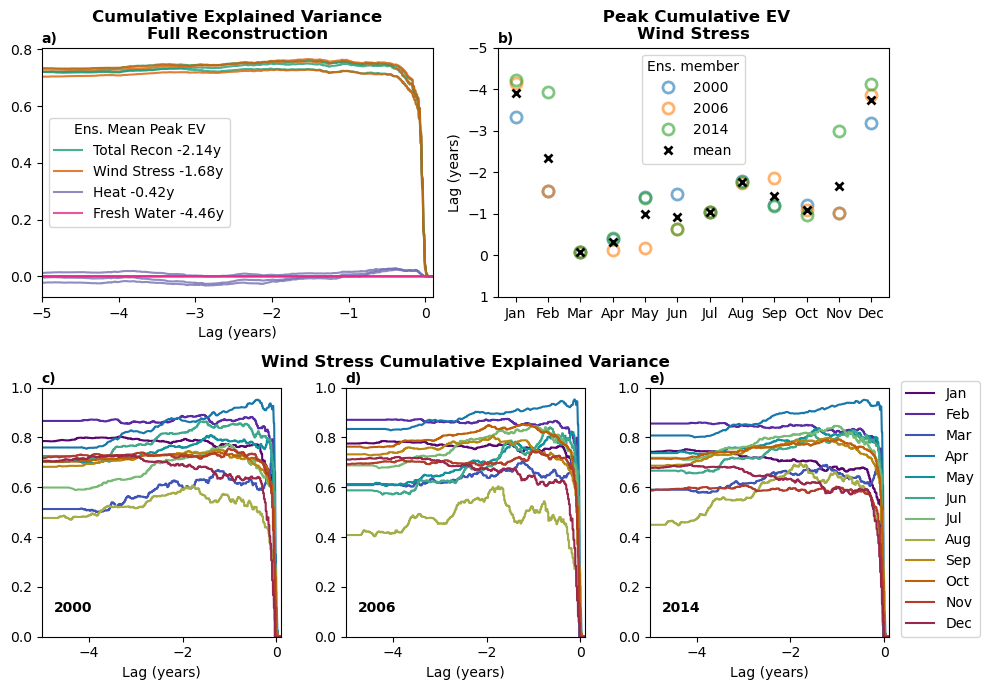

In [12]:
plt.figure(figsize=[10,7])

ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=3)
colors=plt.get_cmap('Dark2')
for year in eyears:
    pps=[]
    for iv,var in enumerate(plotvars):
        p1=cum_ev[year][var].plot(label=var,color=colors(iv),alpha=0.8)
        pps.append(p1[0])

plt.legend(pps,[f'{plotvar_labels[x]} {lag_total[x].mean("eyear").data:1.2f}y' for x in plotvars],title='Ens. Mean Peak EV')
plt.title(f'Cumulative Explained Variance\nFull Reconstruction',fontweight='bold',fontsize=12)
plt.ylabel('')
plt.xlabel('Lag (years)')
plt.xlim([-5,0.1])
plt.text(0.0,1.02,'a)',fontsize=10,fontweight='bold',transform=ax1.transAxes)

ax2 = plt.subplot2grid((2, 6), (0, 3), colspan=3)
plot_var='wind_OCE'
pp2=lag_ds[plot_var].plot(x='month',add_legend=False,hue='eyear',marker='o',ls='',alpha=0.6,markeredgewidth=2,markerfacecolor='none',markersize=8)
pp1=lag_ds[plot_var].mean('eyear').plot(x='month',add_legend=False,marker='x',ls='',markeredgewidth=2,color='k')
plt.title(f' Peak Cumulative EV\nWind Stress',fontweight='bold',fontsize=12)
plt.ylabel('Lag (years)')
plt.ylim([1,-5])
plt.xticks(np.arange(1,13),mth)
plt.xlabel('')
plt.legend(eyears+['mean',],title='Ens. member')
plt.text(0.0,1.02,'b)',fontsize=10,fontweight='bold',transform=ax2.transAxes)

#cmap=plt.get_cmap('RdBu')(np.linspace(0,1,12))
#cmap = cmr.take_cmap_colors('cmr.tropical', 12)
cmap = cmr.take_cmap_colors('cmr.infinity', 12,cmap_range=(0,0.85))
custom_cycler = cycler(color=cmap)

labels=['c)','d)','e)']
bkgd=[0.6,0.8,0.6]
for iy,year in enumerate(eyears):
    iax=plt.subplot2grid((2,6),(1,iy*2),colspan=2)
   # iax.set_facecolor(bkgd)
    plt.text(0.0,1.02,labels[iy],fontsize=10,fontweight='bold',transform=iax.transAxes)
    iax.set_prop_cycle(custom_cycler)
    cum_ev_bym[year][plot_var].sel(month=range(1,13)).plot(x='lag_years',hue='exp',add_legend=False)
    plt.text(0.05,0.1,f'{year}',fontweight='bold',transform=iax.transAxes)
    plt.xlabel('Lag (years)')
    plt.ylabel('')
    plt.ylim([0,1])
    plt.xlim([-5,0.1])
    if iy==1:
        plt.title('Wind Stress Cumulative Explained Variance',fontweight='bold',y=1.05)
    else:
        plt.title('')
plt.legend(mth,loc=[1.05,0],
       #    facecolor=bkgd
          )

plt.tight_layout()
plt.savefig(f'../plots/fig3_cumev_timeseries_peaks.pdf',bbox_inches='tight')